In [82]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [83]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt


In [84]:
# linear regression 
# pseude inverse using SVD
def pseudo_inverse(X):
    U, S, VT = np.linalg.svd(X)
    S_inv = np.zeros((X.shape[1], X.shape[0]))
    for i in range(S.shape[0]):
        S_inv[i,i] = 1/S[i]
    return VT.T @ S_inv @ U.T

# Function to compute B_opt using SVD for a given order
def compute_B_opt(x, y, order):
    # Assuming x and y are already defined and reshaped
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Extend the design matrix X for the given order
    X = np.hstack([x**i for i in range(order + 1)])
    # Perform SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Compute y_prime
    y_prime = U.T @ y
    
    # Compute the pseudoinverse of S
    S_inv = pseudo_inverse(np.diag(S))
    
    # Compute B_opt_prime
    B_opt_prime = S_inv @ y_prime
    
    # Compute B_opt
    B_opt = Vt.T @ B_opt_prime
    
    return B_opt



In [85]:
# Psychometric function
# Psychometric function (Sigmoid)
def logistic_function(intensities,sigma, x_0, mu,lapse_rate,guess_rate):
    func_y= guess_rate+(1-guess_rate-lapse_rate)*(1 / (1 + np.exp(-sigma * ((intensities + mu) - x_0))))
    return func_y

# def psychometric_function(intensities, lapse_rate, mu, sigma):
#     logistic = 1 / (1 + np.exp(-(intensities - mu) / sigma))
#     return lapse_rate + (1  - lapse_rate) * logistic

def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 

def derivative_psychometric_function(intensities, lapse_rate, mu, sigma):
    #F'(x) = (1-lambda)*(1(/sqrt(2*pi)sigma)exp((x-mu)^2/sigma^2)

    return (1 - lapse_rate) * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((intensities - mu) ** 2) / (2 * sigma ** 2))    

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params # Unpack parameters
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(data_grouped,init_guesses=[0,0,0]):
    # takes the grouped data mainly takes the following columns
    intensities=data_grouped['delta_dur_percents'].values
    chose_test=data_grouped['num_of_chose_test'].values
    total_resp=data_grouped['total_responses'].values
    # then fits the psychometric function
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.0001, 0.2), (-1.3, +1.3), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(intensities, chose_test, total_resp),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x

# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)
    return sigma



# Take Data File

In [86]:
# Load data
data_file='ln_auditory_dur_estimate_bin_stair_2025-02-05_15h01.25.318.csv'
#oy_ampVar_35_auditory_dur_estimate_bin_stair_2025-02-05_14h18.49.653.csv'
#lc_auditory_dur_estimate_bin_stair_2025-01-31_14h50.37.771.csv'
#oy_ampvar_5_auditory_dur_estimate_bin_stair_2025-02-05_13h38.21.463.csv'
#lc_auditory_dur_estimate_bin_stair_2025-02-04_15h43.21.906.csv'
#lc_auditory_dur_estimate_bin_stair_2025-01-31_14h50.37.771.csv'
#oy_auditory_dur_estimate_bin_stair_2025-02-03_19h31.51.783.csv'
#IP_auditory_dur_estimate_bin_stair_2025-02-03_15h10.22.718.csv'
#qs_auditory_dur_estimate_bin_stair_2025-01-31_16h36.36.964.csv'
#oy_binfilt45_auditory_dur_estimate_bin_stair_2025-02-01_17h25.06.971.csv'
#lc_auditory_dur_estimate_bin_stair_2025-01-31_14h50.37.771.csv'
#oy_binfilt45_auditory_dur_estimate_bin_stair_2025-02-01_17h25.06.971.csv'
#oy_05_auditory_dur_estimate_bin_stair_2025-02-01_17h02.12.554.csv'
#oy_auditory_dur_estimate_bin_stair_2025-02-01_16h37.53.694.csv'
#oy_auditory_dur_estimate_bin_stair_2025-02-01_00h30.29.272.csv'
#_auditory_dur_estimate_bin_stair_2025-02-01_00h17.59.709.csv'
#oy_auditory_dur_estimate_bin_stair_2025-01-31_22h47.42.399.csv'
#oy_auditory_dur_estimate_bin_stair_2025-01-31_15h44.28.447.csv'
#qs_auditory_dur_estimate_bin_stair_2025-01-31_16h36.36.964.csv'

#oy_auditory_dur_estimate_bin_stair_2025-01-30_15h11.47.538.csv'
#oy_bin_stair_auditory_dur_estimate_bin_stair_2025-01-26_14h23.52.919.csv'
#data_file='_auditory_dur_estimate_2025-01-26_13h31.27.315.csv'# again const
#data_file='_auditory_dur_estimate_2025-01-26_01h24.23.874.csv' #method of constant stimuli
#_auditory_dur_estimate_2025-01-25_23h28.04.509.csv'
#_auditory_dur_estimate_2025-01-25_14h43.56.151.csv'
#_auditory_dur_estimate_2025-01-22_20h53.18.927.csv'
#_auditory_dur_estimate_2025-01-22_22h53.13.975.csv'
#_auditory_dur_estimate_2025-01-22_20h53.18.927.csv'
#_auditory_dur_estimate_2025-01-22_16h43.58.121.csv'
#_auditory_dur_estimate_2025-01-14_20h43.21.525.csv'
#_auditory_dur_estimate_2025-01-08_16h34.13.197.csv'
#_auditory_dur_estimate_2025-01-08_16h34.13.197.csv'
#_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
file_path = 'data/'+data_file
data = pd.read_csv(file_path)
#data=data[:-10]
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)

grouped = data.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('responses', 'count'),
    num_of_chose_standard=('chose_standard', 'sum')
).reset_index()

# p_choose_test
grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']
#sort the group
grouped = grouped.sort_values([ 'standard_dur'])
data[:3]

,Unnamed: 0,standard_dur,rise_dur,order,pre_dur,post_dur,isi_dur,trial_num,total_audio_dur,delta_dur_percents,...,intensities,current_stair,responses,is_correct,response_rts,stair_num_reversal,stair_is_reversal,response_keys,chose_test,chose_standard
0,0,0.8,3.5,1,0.451898,0.375922,0.574377,0,2.869708,-0.05,...,9,3U1D,2.0,True,0.792096,0,False,right,0,1
1,1,0.8,3.5,1,0.529547,0.420946,0.722464,1,3.150021,0.05,...,9,3D1U,1.0,True,0.355772,0,False,left,1,0
2,2,0.8,3.5,2,0.318667,0.539688,0.422262,2,2.247021,-0.70,...,9,lapse_rate,2.0,False,1.793084,0,False,right,1,0


In [87]:
from scipy.stats import linregress
def estimate_initial_guesses(data_grouped, slope_adjustment=1.5, max_sigma_ratio=0.1):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = data_grouped['delta_dur_percents'].values
    chose_test = data_grouped['num_of_chose_test'].values
    total_resp = data_grouped['total_responses'].values
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    
    # Estimate mu (50% crossing point)
    mu_guess = -intercept / slope
    
    # Adjust slope to approximate the maximum
    slope_adjusted = abs(slope) * slope_adjustment
    
    # Calculate sigma using the adjusted slope
    lapse_rate_guess = 0.05  # 3% as a reasonable guess
    sigma_guess = (1 - lapse_rate_guess) / (np.sqrt(2 * np.pi) * slope_adjusted)
    
    # Regularize sigma to avoid overestimation
    intensity_range = max(intensities) - min(intensities)
    max_sigma = intensity_range * max_sigma_ratio
    sigma_guess = min(sigma_guess, max_sigma)
    
    return [lapse_rate_guess, mu_guess, sigma_guess]


def estimate_initial_guesses(data_grouped):
    intensities = data_grouped['delta_dur_percents'].values
    chose_test = data_grouped['num_of_chose_test'].values
    total_resp = data_grouped['total_responses'].values
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    
    # Estimate mu (50% crossing point)
    mu_guess = -intercept / slope
    
    # Estimate sigma using the derived formula
    lapse_rate_guess = 0.05  # 3% as a reasonable guess
    sigma_guess = (1 - lapse_rate_guess) / (np.sqrt(2 * np.pi) * abs(slope))
    sigma_guess = min(sigma_guess, 0.5)  # Regularize sigma to avoid overestimation
    
    return [lapse_rate_guess, mu_guess, sigma_guess]



In [88]:
a=data[data['rise_dur']==5.5]

# -- Fit psychometric function to group A --
group_a=a.groupby(['delta_dur_percents']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('responses', 'count'),
).reset_index()
group_a['p_choose_test'] = group_a['num_of_chose_test'] / group_a['total_responses']
group_a['rise_dur']=0.2 

b=data[data['rise_dur']==3.5]
# -- Fit psychometric function to group B --
group_b=b.groupby(['delta_dur_percents']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('responses', 'count'),
).reset_index()
group_b['p_choose_test'] = group_b['num_of_chose_test'] / group_b['total_responses']
group_b
group_b['rise_dur']=3.5



In [89]:
# # group B
# params_init_b=estimate_initial_guesses(group_b)
# print(f'init guesses for {group_b["rise_dur"][0]} {params_init_b}')

# x_vals = np.linspace(-1,1, 100)
# params_fitted_b=fit_psychometric_function(group_b,params_init_b)
# y_vals = psychometric_function(x_vals, *params_fitted_b)

# plt.plot(x_vals, y_vals)
# plt.scatter(group_b['delta_dur_percents'], group_b['p_choose_test'], label=str(group_b["rise_dur"][0]))
# plt.xlabel('Intensity difference')
# plt.ylabel('P(Chose test)')
# plt.title('Initial guess')
# print(f'For rise duration of {group_b["rise_dur"][0]}, lambda: {params_fitted_b[0]:.3f}, mu: {params_fitted_b[1]:.3f}, sigma: {params_fitted_b[2]:.3f}')


# # group A
# params_init = estimate_initial_guesses(group_a)
# params_init
# # Fit the psychometric function
# params_fitted = fit_psychometric_function(group_a, params_init)
# params_fitted
# print(f'For rise duration of {group_a["rise_dur"][0]} lambda: {params_fitted[0]:.3f}, mu: {params_fitted[1]:.3f}, sigma: {params_fitted[2]:.3f}')

# plt.plot(x_vals, psychometric_function(x_vals, *params_fitted), label=str(group_a["rise_dur"][0]))
# plt.scatter(group_a['delta_dur_percents'], group_a['p_choose_test'])

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)




In [90]:
# group A
# params_init = estimate_initial_guesses(group_b)
# params_init=[0,0,0]
# # Fit the psychometric function
# params_fitted = fit_psychometric_function(group_b, params_init)
# params_fitted
# print(f'lambda: {params_fitted[0]:.3f}, mu: {params_fitted[1]:.3f}, sigma: {params_fitted[2]:.3f}')
# # Plot the fitted psychometric function
# x_vals = np.linspace(-0.8, 0.8, 100)
# y_vals = psychometric_function(x_vals, *params_fitted)
# plt.plot(x_vals, y_vals)
# plt.scatter(group_b['delta_dur_percents'], group_b['p_choose_test'])



In [91]:
group_a=a.groupby(['delta_dur_percents']).agg(
    num_of_chose_test=('chose_test', 'sum'),
    total_responses=('responses', 'count'),
).reset_index()
group_a['p_choose_test'] = group_a['num_of_chose_test'] / group_a['total_responses']


lambda: 0.000, mu: 0.000, sigma: 0.050
Initial guesses: [0.05, -0.6556556556556556, 0.04750475047504751]
λ: 0.050, μ: -0.656, σ: 0.050


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_74864/2749264388.py:43: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


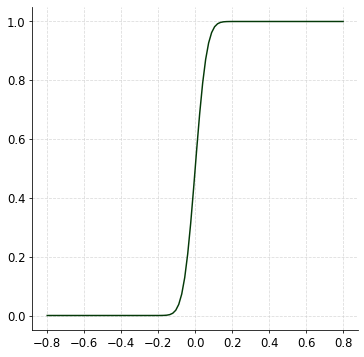

In [92]:

params_init=fit_psychometric_function(group_a)
print(f'lambda: {params_init[0]:.3f}, mu: {params_init[1]:.3f}, sigma: {params_init[2]:.3f}')
x_vals = np.linspace(-0.8, 0.8, 100)

y_vals = psychometric_function(x_vals, *params_init)

x_fit = np.linspace(-1, +1, 1000)
y_fit = psychometric_function(x_fit, params_init[0], params_init[1], params_init[2])
#linear fit
B_opt=compute_B_opt(x_fit,y_fit,1) # returns mx+n function m (slope) and n (scalar) values
[n,m]=B_opt

slope=(1-params_init[0]) *(1/np.sqrt(2*np.pi)*params_init[2])*np.exp(0)

slope=derivative_psychometric_function(0, params_init[0], params_init[1], params_init[2])

linear_y_fit = [(m*i+n) for i in x_fit]#np.sum(B_opt[j] * x_fit**j for j in range(2))

init_sigma = compute_sigma_from_slope(slope, lapse_rate=0.05)
#print(init_sigma)
init_mu= x_fit[round(np.mean((np.where(np.round(linear_y_fit,3)==0.01))[0]))]
init_lapse=0.05
init_guesses=[init_lapse,init_mu,init_sigma]
print(f"Initial guesses: {init_guesses}")
lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(group_a,init_guesses=init_guesses) # Fit psychometric function

print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")
plt.plot(x_vals, y_vals)
plt.scatter(group_a['delta_dur_percents'], group_a['p_choose_test'], label='Data')


In [93]:
data_by_standard = data[data['standard_dur'] == 0.5].copy()
data_by_standard
data_by_standard.loc[:, 'chose_test'] = (data_by_standard['responses'] == data_by_standard['order']).astype(int)
data_by_standard

# Group data by delta_dur_percents and rise_dur
aggregated_data = data_by_standard.groupby(['delta_dur_percents', 'rise_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
).reset_index()
aggregated_data
aggregated_data[aggregated_data['rise_dur'] == 3.5]

,delta_dur_percents,rise_dur,num_of_chose_test,total_responses


Standard  of 0.8s, Rise of 3.5s
Initial guesses: 0.050, -1.114, 0.500
Fitted parameters λ: 0.000, μ: -0.291, σ: 0.331


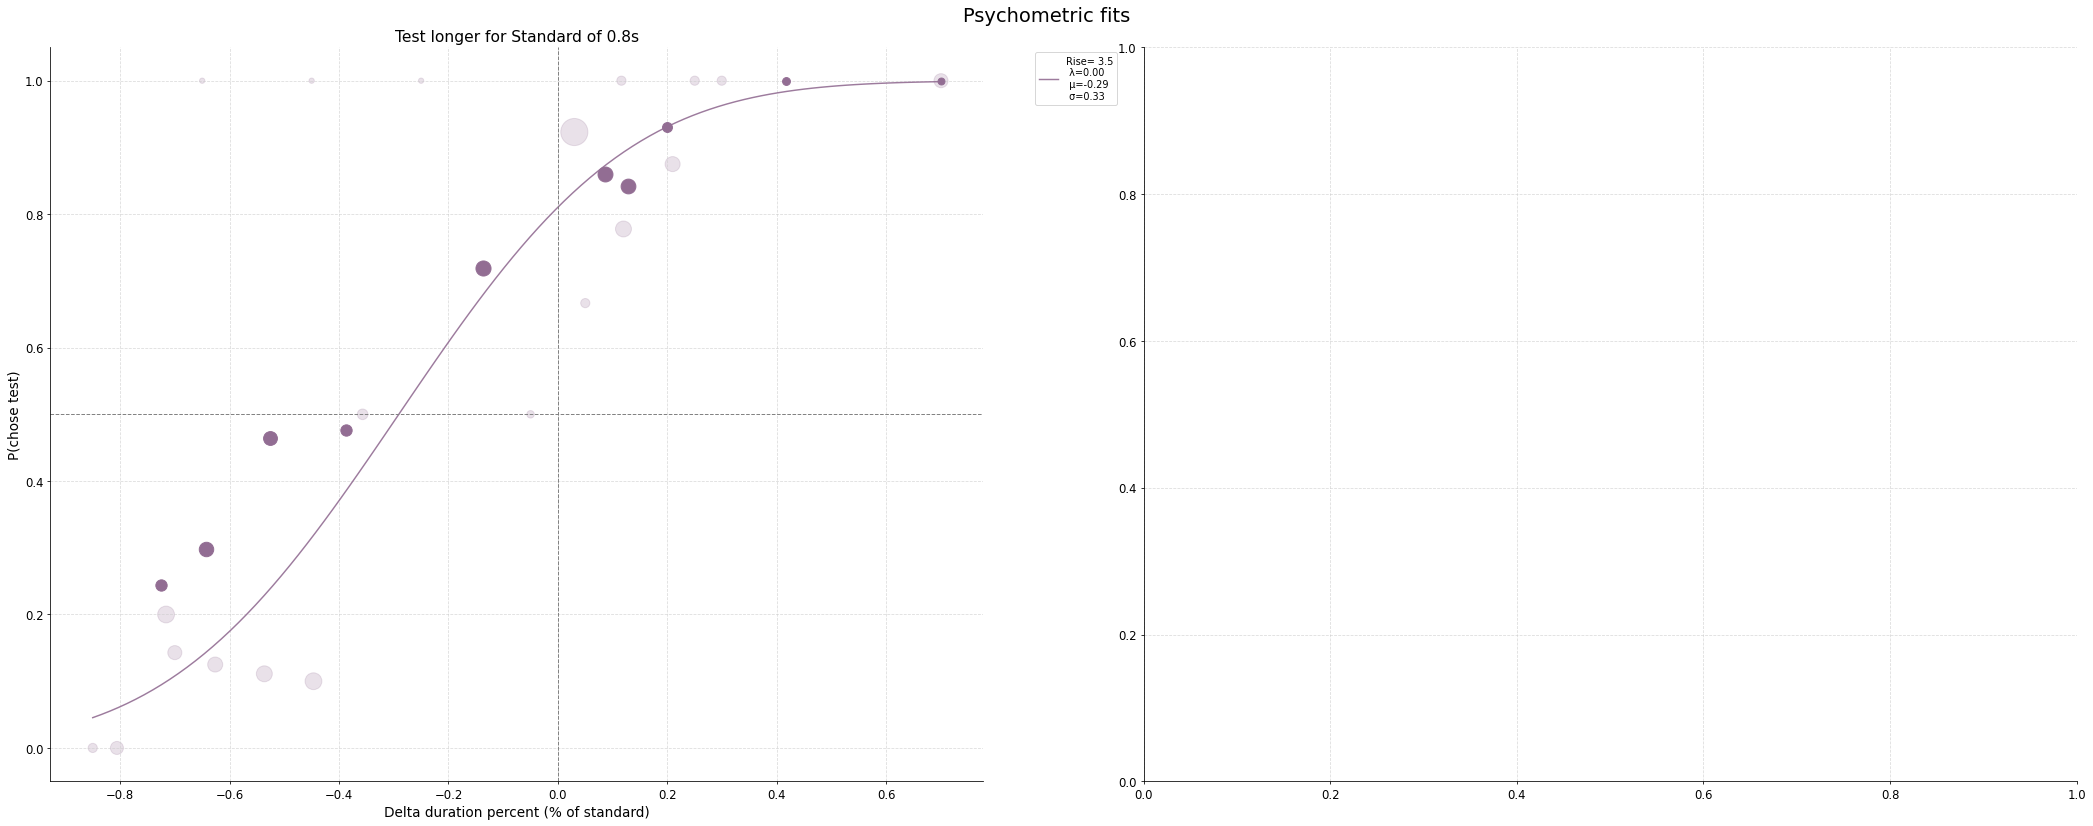

In [103]:
from random import seed
import random
seed(10)
# Generate a random hex color code
def random_hex_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))
# Control color generation within a specific range (e.g., for pastel colors)
def random_pastel_color():
    return (random.uniform(0.6, 1), random.uniform(0.6, 1), random.uniform(0.6, 1))
# Generate a random RGB tuple (values between 0 and 1)
def random_rgb_color():
    return (random.random(), random.random(), random.random())


def plot_psychometric_functions(data):
    fig, axs = plt.subplots(1,2, figsize=(30, 12))
    fig.suptitle('Psychometric fits', fontsize=20)

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    # fildering loop for each standard duration
    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()

        # Group data by delta_dur_percents and rise_dur
        aggregated_data = data_by_standard.groupby(['delta_dur_percents', 'rise_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        # Calculate the probability of choosing the test
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
        # sort the values
        aggregated_data = aggregated_data.sort_values(by='rise_dur')
        # select each rise_dur and fit the psychometric function
        for j in aggregated_data['rise_dur'].unique():
            #lineStyle = '--' if j == 0.80 else '-'  # Different line style for rise_dur=0.050
            #lineColor = 'darkgreen' if j == 4.5 else 'orange'  # Different line color for rise_dur=0.050
            lineColor=random_rgb_color()
            # Filter the data by rise_dur
            X = aggregated_data[aggregated_data['rise_dur'] == j]
   
            params_init = estimate_initial_guesses(X)

            print(f'Standard  of {i}s, Rise of {j}s')
            print(f"Initial guesses: {params_init[0]:.3f}, {params_init[1]:.3f}, {params_init[2]:.3f}")
            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X,init_guesses=params_init) # Fit psychometric function

            print(f"Fitted parameters λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = X['delta_dur_percents']
            y_data = X['p_choose_test']
                        
            # # Normalize bin sizes for scatter plot
            #ax = axs[k // 2, k % 2]
            ax= axs[k]
            X=X.sort_values(by='delta_dur_percents')
            bin_size=10
            bin_distance=0.3
            x_data=X['delta_dur_percents']
            y_data=X['p_choose_test']
            total_bins=X['total_responses']

            for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),bin_size):
                    # search for values +- 0.2 of the i value
                    mask=(x_data>=m-bin_distance) & (x_data<m+bin_distance)
                    # get the mean of the values
                    x_mean=np.mean(x_data[mask])
                    y_mean=np.mean(y_data[mask])
                    # get the total responses
                    total_resp=np.sum(total_bins[mask])
                    # plot the mean values
                    ax.plot(x_mean,y_mean,'o',markersize=((total_resp/np.sum(total_bins)+0.3)*20),color=lineColor)
                    
            
            x_fit = np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            ax.plot(x_fit, y_fit, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}', alpha=0.9,color=lineColor)
                     #linestyle=lineStyle, color=lineColor,)
            # scatter raw data
            ax.scatter(x_data, y_data, s=total_bins*30, color=lineColor, alpha=0.2)
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta duration percent (% of standard)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test longer for Standard of {i}s')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)
# Psychometric function fits when the data is pooled across all standard durations 

In [95]:
def plot_binned_data(X,bin_size=5,color='k'):# X should be grouped data
    X=X.sort_values(by='delta_dur_percents')
    x_data=X['delta_dur_percents']
    y_data=X['p_choose_test']
    total_bins=X['total_responses']
    x_bins=np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),15)
    for i in range(len(x_data)):
        plt.plot(np.mean(x_data[i-bin_size:i+bin_size]),np.mean(y_data[i:i+bin_size]),'o', 
                markersize=np.sum(total_bins[i:i+bin_size])/np.sum(total_bins)*30,color=color)

# data = data.sort_values(by='standard_dur')
# data_by_rise = data[data['rise_dur'] == 0.245].copy()
# data_by_rise=data_by_rise.sort_values(by='rise_dur')    
# aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
#                 num_of_chose_test=('chose_test', 'sum'),
#                 total_responses=('responses', 'count'),
#         ).reset_index()
# aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

# plot_binned_data(aggregated_data,bin_size=5,color='r')


# Functions to pool data across standard durations

In [96]:
def data_grouped_standard(data,rise_cond,standard_dur):
    """  
    This function groups the data by standard duration and rise condition
    """
    data = data.sort_values(by='standard_dur') # sort the data by standard duration
    data_by_rise = data[data['rise_dur'] == rise_cond].copy() # filter the data by rise condition
    
    # group the data by delta duration and standard duration
    aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                    num_of_chose_test=('chose_test', 'sum'),
                    total_responses=('responses', 'count'),
            ).reset_index()
    # calculate the probability of choosing test
    aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

    # sort the values
    aggregated_data = aggregated_data.sort_values(by='standard_dur')

    # filter the data by standard duration
    aggregated_data = aggregated_data[aggregated_data['standard_dur'] == standard_dur].copy()
    
    return aggregated_data

a=data_grouped_standard(data,0.05,1)
a[:2]

,delta_dur_percents,standard_dur,num_of_chose_test,total_responses,p_choose_test


λ: 0.003, μ: -0.291, σ: 0.329


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_74864/2749264388.py:43: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


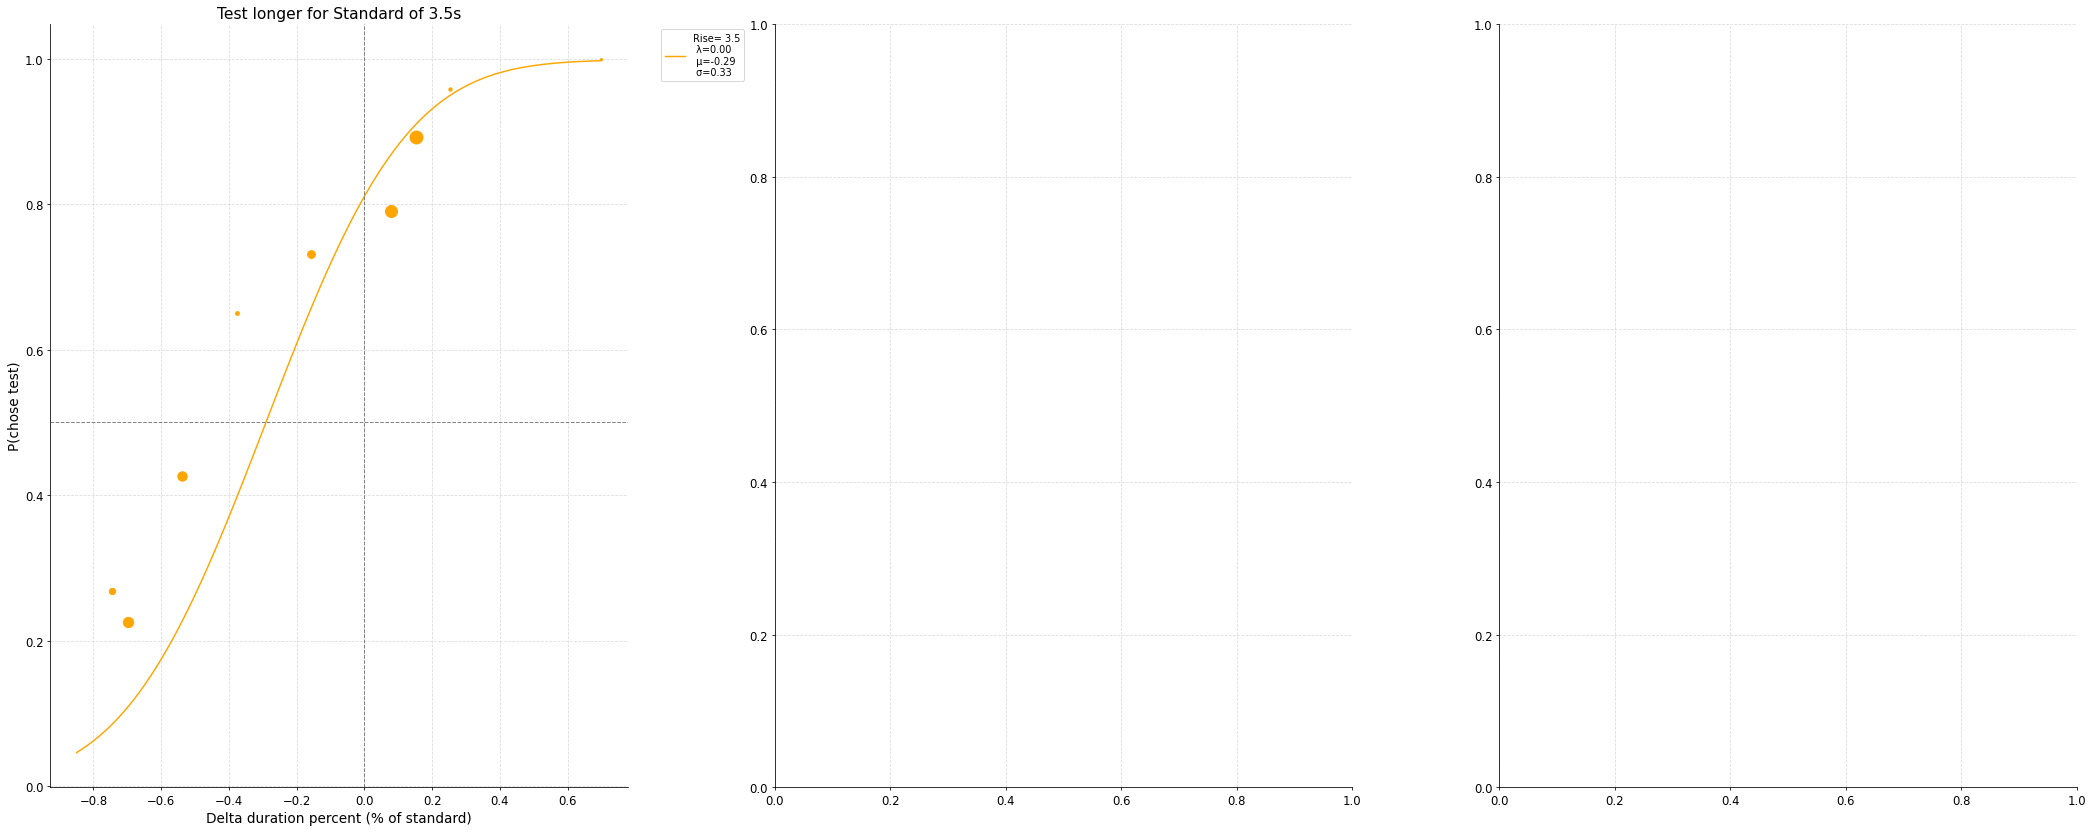

In [97]:
# plot seperate psychometric functions for each rise condition and standard duration
def plot_psychometric_functions(data):
    fig, axs = plt.subplots(1, 3, figsize=(30, 12))

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    
    for k, i in enumerate(data['rise_dur'].unique()):
        # Filter data by standard duration
        data_by_rise = data[data['rise_dur'] == i].copy()
        # take the choose test column if  response is equal to test order
        data_by_rise.loc[:, 'chose_test'] = (data_by_rise['responses'] == data_by_rise['order']).astype(int)


        aggregated_data = data_by_rise.groupby(['delta_dur_percents', 'standard_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']

        # sort the values
        aggregated_data = aggregated_data.sort_values(by='standard_dur')
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(aggregated_data)

        for idx_data, j in enumerate(aggregated_data['standard_dur'].unique()):
            lineStyle = '--' if i == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if i == 0.050 else 'orange'  # Different line color for rise_dur=0.050

            Y = aggregated_data[aggregated_data['standard_dur'] == j]
            print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = Y['delta_dur_percents']
            y_data = Y['p_choose_test']
            

            #ax = axs[idx_data // 2, idx_data % 2]
            ax= axs[idx_data]
            # ax.scatter(bin_centers, y_data_smooth_binned, s=bin_sizes_normalized, alpha=0.3)

            #ax.scatter(bin_centers, y_data_smooth_binned, alpha=0.3)
            X=data_grouped_standard(data,i,j)
            X=X.sort_values(by='delta_dur_percents')
            bin_size=3
            x_data=X['delta_dur_percents']
            y_data=X['p_choose_test']
            total_bins=X['total_responses']

            for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),10):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-0.2) & (x_data<m+0.2)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                
            #ax.scatter(x_data,y_data)
            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {i}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta duration percent (% of standard)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test longer for Standard of {i}s')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)


## Bootstrap

In [98]:
# Fit the psychometric function to the original data
lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(grouped)

# Original parameter values
print(f"Original Fit: λ = {lambda_hat}, μ = {mu_hat}, σ = {sigma_hat}")



/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_74864/2749264388.py:43: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


Original Fit: λ = 0.0033360446590647453, μ = -0.2906204141328218, σ = 0.32872672703412475


#### 2. Simulating Bootstrap Data python Copy code

In [99]:
# Generate a single parametric bootstrap dataset
def generate_parametric_bootstrap(original_data):
    simulated_data = original_data.copy()
    lambda_, mu_, sigma_ = fit_psychometric_function(original_data)

    for idx, row in simulated_data.iterrows():
        x = row['delta_dur_percents']
        n_trials = row['total_responses']
        
        # Compute the probability of "chose test" using the psychometric function
        p = psychometric_function(x, lambda_, mu_, sigma_)
        
        # Simulate responses as binomial random draws
        simulated_responses = np.random.binomial(n=n_trials, p=p)
        simulated_data.at[idx, 'num_of_chose_test'] = simulated_responses
    
    return simulated_data


#### 3. Bootstrapping the fit

In [100]:

def full_bootstraping(data, n_bootstrap):
    bootstrap_fits = []
    bootstraps=[]
    for _ in range(n_bootstrap):
        # Generate a bootstrap dataset
        bootstrap_data = generate_parametric_bootstrap(data)
        bootstraps.append(bootstrap_data)
        # Re-fit the psychometric function to the bootstrap data
        lambda_, mu_, sigma_ = fit_psychometric_function(bootstrap_data) 

        x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        #linear fit
        B_opt=compute_B_opt(x_fit,y_fit,1) # returns mx+n function m (slope) and n (scalar) values
        [n,m]=B_opt
        linear_y_fit = [(m*i+n) for i in x_fit]#np.sum(B_opt[j] * x_fit**j for j in range(2))
        # if we fit a straight line (lin reg) to the psycometric func the point where it goes through 50% is a good initial guess for mu
        # and slope of regression is a decent guess(likely underestimate) which can be translated to sigma.
        # lapse rate 3 or 5 perccent is fine
        init_sigma=float(m)
        init_mu= x_fit[round(np.mean((np.where(np.round(linear_y_fit,1)==0.05))[0]))]
        init_lapse=0.05
        init_guesses=[init_lapse,init_mu,init_sigma]
        #print(init_guesses)
        lambda_, mu_, sigma_= fit_psychometric_function(bootstrap_data,init_guesses=init_guesses) # Fit psychometric function       

        bootstrap_fits.append([lambda_, mu_, sigma_])
    bootstrap_fits = pd.DataFrame(bootstrap_fits, columns=['lambda', 'mu', 'sigma'])
    bootstraps = pd.concat(bootstraps)
    bootstraps["p_choose_test"] = bootstraps["num_of_chose_test"] / bootstraps["total_responses"]
    return bootstrap_fits, bootstraps

bootstrap_fits, bootstraps = full_bootstraping(grouped, 100)
bootstraps

/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_74864/2749264388.py:43: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(
/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_74864/3456411606.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  init_sigma=float(m)
/opt/miniconda3/envs/mathmod/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/mathmod/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

#### 4. Analyzing Bootstrap Results


In [ ]:
bootstrap_fits['lambda']

In [ ]:
# Calculate 95% confidence intervals for each parameter
lambda_ci = np.percentile(bootstrap_fits['lambda'], [2.5, 97.5])
mu_ci = np.percentile(bootstrap_fits['mu'], [2.5, 97.5])
sigma_ci = np.percentile(bootstrap_fits['sigma'], [2.5, 97.5])

print(f"λ 95% CI: {lambda_ci}")
print(f"μ 95% CI: {mu_ci}")
print(f"σ 95% CI: {sigma_ci}")

# Plot the bootstrap distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(bootstrap_fits['lambda'], kde=True)
plt.axvline(lambda_hat, color='red', linestyle='--')
plt.title('λ')

plt.subplot(1, 3, 2)
sns.histplot(bootstrap_fits['mu'], kde=True)
plt.axvline(mu_hat, color='red', linestyle='--')
plt.title(' μ')

plt.subplot(1, 3, 3)
sns.histplot(bootstrap_fits['sigma'], kde=True)
plt.axvline(sigma_hat, color='red', linestyle='--')
plt.title('σ')


In [ ]:
# data frame for the bootstrap fits parameters
lambda_bootstraps = []
mu_bootstraps = []
sigma_bootstraps = []

def pregrouped_plot_psychometric_functions(data):
    fig, axs = plt.subplots(1, 3, figsize=(36, 16))

    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()

        # Plot psychometric functions
        for j in data_by_standard['rise_dur'].unique():
            lineStyle = '--' if i == 0.050 else '-'  # Different line style for rise_dur=0.050
            lineColor = 'darkgreen' if j == 0.80 else 'orange'  # Different line color for rise_dur=0.050

            data_by_standard_and_rise = data_by_standard[data_by_standard['rise_dur'] == j]

            # bootstrap Y
            y_bootstrap_fits, y_bootstraps = full_bootstraping(data_by_standard_and_rise, 1000)

            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(y_bootstraps)
            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            #linear fit
            B_opt=compute_B_opt(x_fit,y_fit,1) # returns mx+n function m (slope) and n (scalar) values
            [n,m]=B_opt
            linear_y_fit = [(m*i+n) for i in x_fit]#np.sum(B_opt[j] * x_fit**j for j in range(2))
            # if we fit a straight line (lin reg) to the psycometric func the point where it goes through 50% is a good initial guess for mu
            # and slope of regression is a decent guess(likely underestimate) which can be translated to sigma.
            # lapse rate 3 or 5 perccent is fine
            init_sigma=float(m)
            init_mu= x_fit[round(np.mean((np.where(np.round(linear_y_fit,1)==0.5))[0]))]
            init_lapse=0.05
            init_guesses=[init_lapse,init_mu,init_sigma]
            #print(init_guesses)
            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(y_bootstraps,init_guesses=init_guesses) # Fit psychometric function
            
            lambda_bootstraps.append(y_bootstrap_fits["lambda"])
            mu_bootstraps.append(y_bootstrap_fits["mu"])
            sigma_bootstraps.append(y_bootstrap_fits["sigma"])


            print(f"λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = y_bootstraps['delta_dur_percents']
            y_data = y_bootstraps['p_choose_test']
            total_bins=y_bootstraps['total_responses']            
            # Normalize bin sizes for scatter plot
            #ax = axs[k // 2, k % 2]
            ax= axs[k]

            for m in np.linspace(min(y_bootstraps['delta_dur_percents']),max(y_bootstraps['delta_dur_percents']),10):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-0.2) & (x_data<m+0.2)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
                

            x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)

            ax.plot(x_fit, y_fit, linestyle=lineStyle, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}',color=lineColor)
            ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
            ax.set_xlabel('Delta Duration (s)')
            ax.set_ylabel('P(chose test)')
            ax.set_title(f'Test is longer responses for comparison of {i}s')
            
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            # remove axspines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
    plt.tight_layout()
    plt.show()

pregrouped_plot_psychometric_functions(grouped)


In [ ]:
from scipy import stats
 
index=0
plt.figure(figsize=(24, 24))
plt.suptitle(f"Bootstrapped parameters")   

for k, i in enumerate(data['standard_dur'].unique()):
    data_by_standard = data[data['standard_dur'] == i].copy()
    for j in data_by_standard['rise_dur'].unique():
        # Plot the bootstrap distributions
        print(index)     
        plt.subplot(6, 3, 3*index+1)
        
        kde = stats.gaussian_kde(lambda_bootstraps[index])
        #plt.plot(kde.pdf(lambda_bootstraps[0]))
        plt.hist(lambda_bootstraps[index],density=True,
                label=f"Rise={j}\nStandard={i}", alpha=0.6)
        xx = np.linspace(0, max(lambda_bootstraps[index]), 1000)
        plt.plot(xx, kde(xx),color='darkgreen')
        plt.ylabel('Count') 
        # sns.histplot(lambda_bootstraps[index].values, kde=True)
        #plt.axvline(lambda_hat, color='red', linestyle='--')
        plt.title('λ') if index==0 else None
        plt.legend()

        plt.subplot(6, 3, 3*index+2)
        sns.histplot(mu_bootstraps[index].values, kde=True) 
        #plt.axvline(mu_hat, color='red', linestyle='--')
        plt.title(' μ') if index==0 else None

        plt.subplot(6, 3, 3*index+3)
        sns.histplot(sigma_bootstraps[index].values, kde=True)
        #plt.axvline(sigma_hat, color='red', linestyle='--')
        plt.title('σ') if index==0 else None
        #plt.legend(f"Bootstrapped parameters for Rise={j} and Standard={i}")
        index+=1

In [ ]:
a=lambda_bootstraps[2].values
a[2]

In [ ]:

# Calculate 95% confidence intervals for each parameter
lambda_bootstraps = np.array(lambda_bootstraps)
mu_bootstraps = np.array(mu_bootstraps)
sigma_bootstraps = np.array(sigma_bootstraps)

lambda_ci = np.percentile(lambda_bootstraps, [2.5, 97.5], axis=0)
mu_ci = np.percentile(mu_bootstraps, [2.5, 97.5], axis=0)
sigma_ci = np.percentile(sigma_bootstraps, [2.5, 97.5], axis=0)

#plot
for k, i in enumerate(data['standard_dur'].unique()):
    data_by_standard = data[data['standard_dur'] == i].copy()
    for j in data_by_standard['rise_dur'].unique():
        plt.plot()




In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(36, 12))
for idx_stand, standard_ in enumerate(data['standard_dur'].unique()):
    for idx_rise, rise_dur_ in enumerate(data['rise_dur'].unique()):
        X = grouped[
            (grouped['standard_dur'] == standard_) & 
            (grouped['rise_dur'] == rise_dur_)
        ]
        # sort X
        X = X.sort_values('standard_dur')
        lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X)
        print(f'Standard: {standard_}, Rise: {rise_dur_}')
        lineStyle = '--' if rise_dur_ == 0.60 else '-'  # Different line style for rise_dur=0.050
        lineColor = 'darkgreen' if rise_dur_ == 0.80 else 'orange'  # Different line color for rise_dur=0.050

        x_data = X['delta_dur_percents']
        y_data = X['p_choose_test']

        #ax = axs[idx_stand // 2, idx_stand % 2]
        ax= axs[idx_stand]
        bin_size=10
        bin_distance=0.3
        x_data=X['delta_dur_percents']
        y_data=X['p_choose_test']
        total_bins=X['total_responses']
        for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),bin_size):
                # search for values +- 0.2 of the i value
                mask=(x_data>=m-bin_distance) & (x_data<m+bin_distance)
                # get the mean of the values
                x_mean=np.mean(x_data[mask])
                y_mean=np.mean(y_data[mask])
                # get the total responses
                total_resp=np.sum(total_bins[mask])
                # plot the mean values
                ax.plot(x_mean,y_mean,'o',markersize=total_resp/np.sum(total_bins)*30,color=lineColor)
        
        x_fit = np.linspace(min(data['delta_dur_percents']), max(data['delta_dur_percents']), 100)
        y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
        ax.plot(x_fit, y_fit, linestyle=lineStyle, color=lineColor, label=f'Rise= {rise_dur_}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}')
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
        ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Delta duration percent (% of standard)')
        ax.set_ylabel('P(chose test)')
        ax.set_title(f'Test longer for Standard of {standard_}s')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # remove axspines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Figure2a: Psychometric functions for different standard durations. The x-axis represents the difference in duration between the standard and test stimuli as a percentage of the standard duration. The y-axis represents the probability of choosing the test stimulus. 
# The data is grouped by the standard duration and rise duration. The psychometric function is fitted to the data for each group. 
